In [24]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
zip_path = "/content/drive/MyDrive/Racist Sexist or Not Dataset.zip"
!unzip -q "/content/drive/MyDrive/Racist Sexist or Not Dataset.zip" -d "/content/"

replace /content/Racist Sexist or Not Dataset/7.Description Racist - Sexist or Not.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [26]:
import os

# Define the path to the folder and file
train_dir = "/content/Racist Sexist or Not Dataset/Train/train_racisit.csv"
test_dir = '/content/Racist Sexist or Not Dataset/Test/test_racisit.csv'

# Check if train file exists
if os.path.exists(train_dir):
    print("found")
else:
    print("not found")

# Check if test directory exists
if os.path.exists(test_dir):
    print("found")
else:
    print("not found")


found
found


**3.1 Text Preprocessing, Tokenization, and Sequence Padding**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


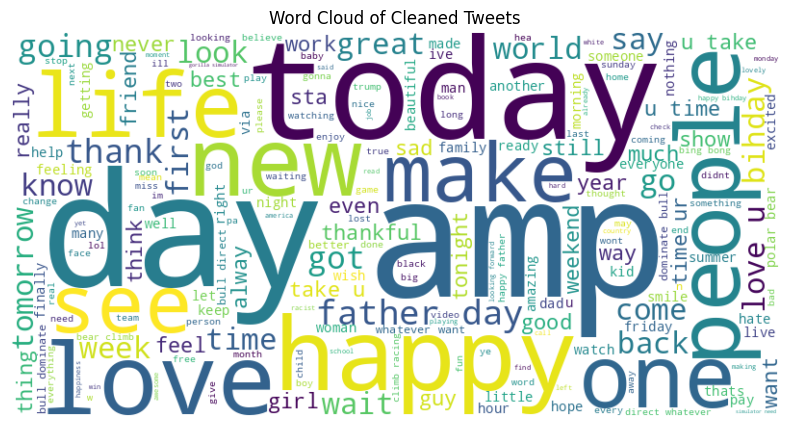

In [30]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load Dataset
df = pd.read_csv('/content/Racist Sexist or Not Dataset/Train/train_racisit.csv')
df = df[['tweet', 'label']]

# Contractions
contractions = {
    "don't": "do not", "doesn't": "does not", "can't": "cannot", "i'm": "i am",
    "you're": "you are", "it's": "it is", "they're": "they are", "isn't": "is not",
    "aren't": "are not", "wasn't": "was not", "weren't": "were not"
}

def expand_contractions(text):
    for key, val in contractions.items():
        text = text.replace(key, val)
    return text

# Text Cleaning
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = expand_contractions(text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned'] = df['tweet'].apply(clean_text)

# Visualization
all_words = ' '.join(df['cleaned'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Tweets")
plt.show()

# Train-test split
X = df['cleaned'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding (95th percentile)
lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(lengths, 95))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


**3.2 Model Building and Training**

**1. Model 1 – Simple RNN**

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

vocab_size = len(word_index) + 1
embedding_dim = 100

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()
model_rnn.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test), batch_size=32)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.9349 - loss: 0.2314 - val_accuracy: 0.9453 - val_loss: 0.1671
Epoch 2/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9764 - loss: 0.0760 - val_accuracy: 0.9399 - val_loss: 0.1887
Epoch 3/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9907 - loss: 0.0310 - val_accuracy: 0.9299 - val_loss: 0.2415
Epoch 4/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.9932 - loss: 0.0224 - val_accuracy: 0.9312 - val_loss: 0.2701
Epoch 5/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.9948 - loss: 0.0170 - val_accuracy: 0.9362 - val_loss: 0.2713


**Model 2 – LSTM with Trainable Embedding**

In [34]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()
model_lstm.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test), batch_size=32)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.9346 - loss: 0.2467 - val_accuracy: 0.9467 - val_loss: 0.1696
Epoch 2/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.9665 - loss: 0.1018 - val_accuracy: 0.9468 - val_loss: 0.1626
Epoch 3/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - accuracy: 0.9810 - loss: 0.0589 - val_accuracy: 0.9467 - val_loss: 0.1714
Epoch 4/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step - accuracy: 0.9889 - loss: 0.0357 - val_accuracy: 0.9442 - val_loss: 0.2308
Epoch 5/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 45s 34ms/step - accuracy: 0.9909 - loss: 0.0286 - val_accuracy: 0.9298 - val_loss: 0.2884


**Model 3 – LSTM with Pretrained Word2Vec Embeddings**

In [35]:
import gensim.downloader as api

# Load Word2Vec
w2v_model = api.load("word2vec-google-news-300")

embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model:
        embedding_matrix[i] = w2v_model[word]

# Model with pretrained embeddings
model_w2v = Sequential()
model_w2v.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_len, trainable=False))
model_w2v.add(LSTM(64))
model_w2v.add(Dense(1, activation='sigmoid'))

model_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_w2v.summary()
model_w2v.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test), batch_size=32)


[==================================================] 100.0% 1662.8/1662.8MB downloaded


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │       5,458,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,458,500 (20.82 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,458,500 (20.82 MB)

Epoch 1/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.9292 - loss: 0.2438 - val_accuracy: 0.9381 - val_loss: 0.1785
Epoch 2/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.9472 - loss: 0.1543 - val_accuracy: 0.9427 - val_loss: 0.1677
Epoch 3/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.9489 - loss: 0.1481 - val_accuracy: 0.9438 - val_loss: 0.1663
Epoch 4/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.9537 - loss: 0.1381 - val_accuracy: 0.9462 - val_loss: 0.1638
Epoch 5/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.9600 - loss: 0.1201 - val_accuracy: 0.9448 - val_loss: 0.1760


**3.3 (a) Model Training and Evaluation**

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9957 - loss: 0.0143 - val_accuracy: 0.9348 - val_loss: 0.2868
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9959 - loss: 0.0136 - val_accuracy: 0.9244 - val_loss: 0.3129
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9950 - loss: 0.0136 - val_accuracy: 0.9343 - val_loss: 0.2638
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9972 - loss: 0.0111 - val_accuracy: 0.9102 - val_loss: 0.3569
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9973 - loss: 0.0096 - val_accuracy: 0.9310 - val_loss: 0.3295
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9965 - loss: 0.0119 - val_accuracy: 0.9302 - val_loss: 0.3431


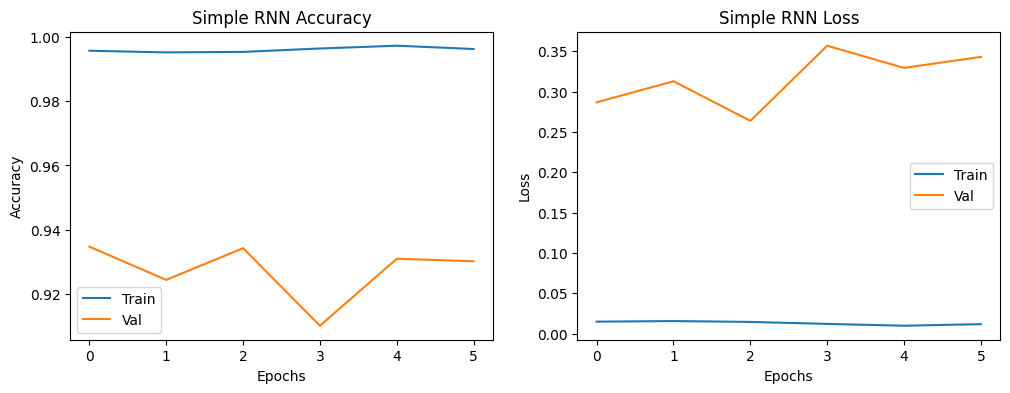

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9933 - loss: 0.0224 - val_accuracy: 0.9259 - val_loss: 0.3198
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9943 - loss: 0.0189 - val_accuracy: 0.9404 - val_loss: 0.2823
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.9947 - loss: 0.0167 - val_accuracy: 0.9429 - val_loss: 0.3153
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.9955 - loss: 0.0126 - val_accuracy: 0.9298 - val_loss: 0.3119
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9950 - loss: 0.0147 - val_accuracy: 0.9201 - val_loss: 0.3556


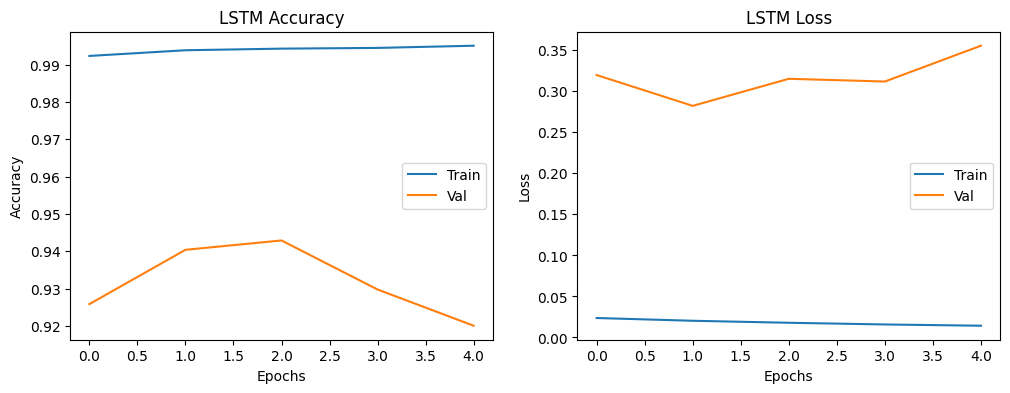

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9633 - loss: 0.1107 - val_accuracy: 0.9456 - val_loss: 0.1682
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9651 - loss: 0.1018 - val_accuracy: 0.9437 - val_loss: 0.1703
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9706 - loss: 0.0872 - val_accuracy: 0.9471 - val_loss: 0.1701
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9732 - loss: 0.0789 - val_accuracy: 0.9487 - val_loss: 0.1691


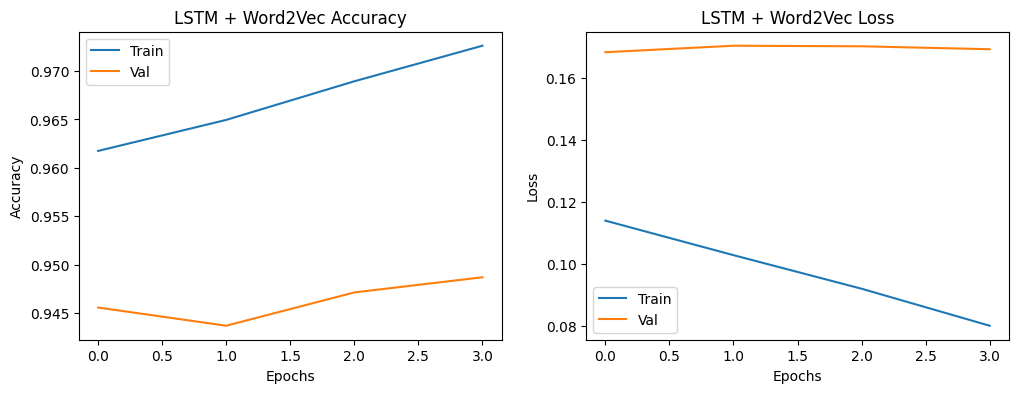

In [36]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def train_model(model, X_train, y_train, X_val, y_val, name):
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    # Plot
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    return model

# Train and Plot for all models
model_rnn = train_model(model_rnn, X_train_pad, y_train, X_test_pad, y_test, "Simple RNN")
model_lstm = train_model(model_lstm, X_train_pad, y_train, X_test_pad, y_test, "LSTM")
model_w2v = train_model(model_w2v, X_train_pad, y_train, X_test_pad, y_test, "LSTM + Word2Vec")


**3.3 (b) Evaluation (Accuracy, Confusion Matrix, Classification Report)**

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Simple RNN Accuracy: 0.9343
Simple RNN Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5937
           1       0.55      0.47      0.51       456

    accuracy                           0.93      6393
   macro avg       0.75      0.72      0.74      6393
weighted avg       0.93      0.93      0.93      6393



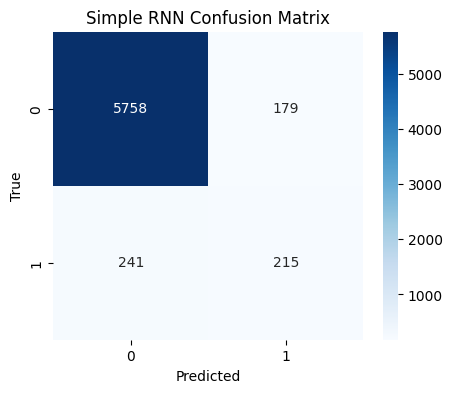

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

LSTM Accuracy: 0.9404
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5937
           1       0.59      0.53      0.56       456

    accuracy                           0.94      6393
   macro avg       0.78      0.75      0.76      6393
weighted avg       0.94      0.94      0.94      6393



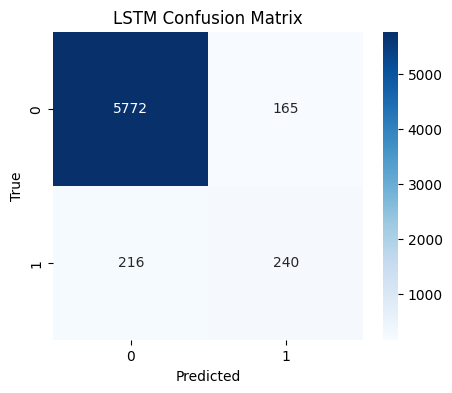

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

LSTM + Word2Vec Accuracy: 0.9456
LSTM + Word2Vec Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5937
           1       0.66      0.48      0.56       456

    accuracy                           0.95      6393
   macro avg       0.81      0.73      0.76      6393
weighted avg       0.94      0.95      0.94      6393



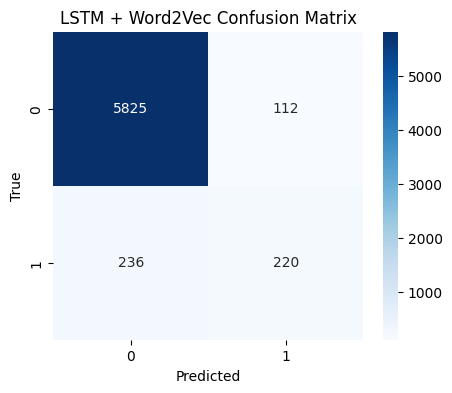

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, X_test, y_test, name):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    print(f"\n{name} Accuracy: {acc:.4f}")
    print(f"{name} Classification Report:\n{cr}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(model_rnn, X_test_pad, y_test, "Simple RNN")
evaluate_model(model_lstm, X_test_pad, y_test, "LSTM")
evaluate_model(model_w2v, X_test_pad, y_test, "LSTM + Word2Vec")


**3.4 GUI for Real-Time Prediction (Gradio)**

In [39]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.8 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def preprocess_input(text):
    text = clean_text(text)
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    return pad

def predict_tweet(input_text):
    preprocessed = preprocess_input(input_text)
    pred = model_w2v.predict(preprocessed)[0][0]  # Using LSTM + Word2vec model here
    result = "Offensive" if pred > 0.5 else "Not Offensive"
    confidence = round(pred*100 if pred > 0.5 else (1-pred)*100, 2)
    return f"Prediction: {result} (Confidence: {confidence}%)"

interface = gr.Interface(
    fn=predict_tweet,
    inputs=gr.Textbox(lines=3, placeholder="Enter tweet..."),
    outputs="text",
    title="Tweet Classifier",
    description="Detects whether a tweet is offensive or not using an LSTM model."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://669e2cad7aaf6d4edf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
